In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import time
from tqdm import tqdm
from sklearn import metrics
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from torch.utils.data.sampler import WeightedRandomSampler
from collections import Counter

In [2]:
df = pd.read_csv('del_freq_words.csv', index_col=0)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4337 entries, 0 to 4336
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   url              4337 non-null   object
 1   title            4337 non-null   object
 2   theme            4337 non-null   object
 3   tags             4337 non-null   object
 4   read_time        4337 non-null   int64 
 5   number_of_views  4337 non-null   int64 
 6   date             4337 non-null   object
 7   amount_of_imgs   4337 non-null   int64 
 8   comments         4337 non-null   int64 
 9   bookmark         4337 non-null   int64 
 10  votes            4337 non-null   int64 
 11  text             4337 non-null   object
dtypes: int64(6), object(6)
memory usage: 440.5+ KB


In [4]:
df

,url,title,theme,tags,read_time,number_of_views,date,amount_of_imgs,comments,bookmark,votes,text
0,https://habr.com/ru/articles/842474/,На Alibaba можно купить станок для изготовлени...,Научно-популярное,"['Научно-популярное', 'Физика']",4,2800,2024-09-11 14:58:00,0,4,3,0,производство бриллиант стать дешёвый либо созд...
1,https://habr.com/ru/articles/842336/,"Учёные, искавшие жизнь на Марсе, услышали сигн...",Научно-популярное,"['Научно-популярное', 'Астрономия']",8,1600,2024-09-11 13:38:00,0,1,2,0,радиоприёмник создать поле сражение первый мир...
2,https://habr.com/ru/companies/montirey/article...,Проявление свойств эфира: доказано эксперимент...,Блог компании Мон Тирэй,"['Блог компании Мон Тирэй', 'Научно-популярное...",7,3700,2024-09-11 11:24:00,0,44,5,0,исследование российский учёный подтвердить сущ...
3,https://habr.com/ru/companies/timeweb/articles...,Деннис Макалистэйр Ритчи. Между Unix и С / Хабр,Блог компании Timeweb Cloud,"['Блог компании Timeweb Cloud', 'Читальный зал...",18,1300,2024-09-11 11:05:00,0,0,11,0,создатель точнее описывать ритча именно слово ...
4,https://habr.com/ru/articles/842324/,Болезнь Альцгеймера может оказаться аутоиммунн...,Научно-популярное,"['Научно-популярное', 'Мозг', 'Здоровье']",4,840,2024-09-11 10:49:00,0,0,4,0,поиск лекарство болезнь альцгеймер становиться...
...,...,...,...,...,...,...,...,...,...,...,...,...
4332,https://habr.com/ru/companies/selectel/article...,От кофеварки до кардиостимуляторов. Боимся IoT...,Блог компании Selectel,"['Блог компании Selectel', 'Информационная без...",5,6700,2021-08-11 15:36:00,0,23,20,31,источник интернет вещь резко предмет вокруг пр...
4333,https://habr.com/ru/companies/ua-hosting/artic...,Ритм на кончиках пальцев: считывание сигналов ...,Блог компании ua-hosting.company,"['Блог компании ua-hosting.company', 'Научно-п...",13,2100,2021-08-11 15:21:00,6,0,20,13,воспринимать окружающий мир посредством набор ...
4334,https://habr.com/ru/articles/572266/,Фомальгаут / Хабр,Научно-популярное,"['Научно-популярное', 'Астрономия']",4,17000,2021-08-10 23:56:00,7,20,37,47,альфа южный рыба увидеть фомальгаут москва зна...
4335,https://habr.com/ru/articles/572046/,Морской чёртик и морской ангел / Хабр,Научно-популярное,"['Научно-популярное', 'Биология']",5,9400,2021-08-10 21:52:00,0,7,11,11,внимание получаться тема глубинный обитатель н...


In [5]:
df['text'].map(lambda x: len(x.split())).describe()

count     4337.000000
mean      1206.523403
std        859.305958
min         13.000000
25%        665.000000
50%       1023.000000
75%       1492.000000
max      14234.000000
Name: text, dtype: float64

theme
Научно-популярное                   1387
Блог компании RUVDS.com              338
Блог компании ua-hosting.company     280
Блог компании FirstVDS               218
Читальный зал                        196
Блог компании Timeweb Cloud          194
Математика*                          120
Блог компании Онлайн Патент          109
Блог компании МТС                     91
Блог компании Белая Радуга            64
Name: url, dtype: int64


Text(0.5, 1.0, 'Top 10 popular topics')

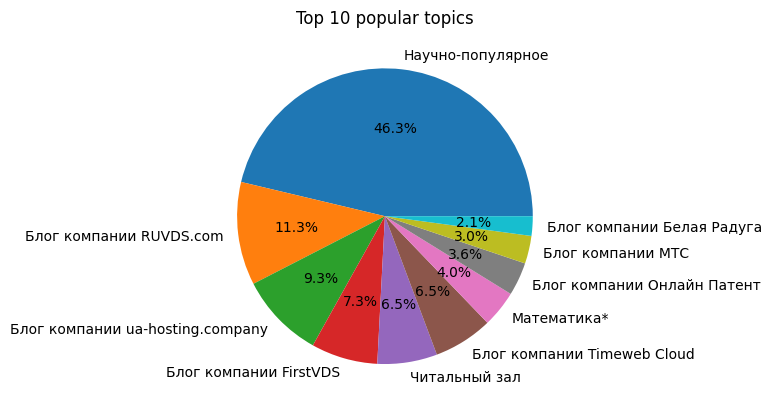

In [6]:
x = df.groupby('theme').count()
x = x.sort_values(by='url', ascending = False)[:10]
print(x['url'])

plt.pie(x['url'], labels=x.index, autopct='%1.1f%%')
plt.title('Top 10 popular topics')

# Бинарная классификация
- определить является ли статься "Блогом компании XXX"

In [3]:
df1 = df[['text', 'theme']]

In [4]:
def create_target(row):
    if 'блог компании' in row['theme'].lower():
        row['target'] = 1
    else:
        row['target'] = 0
    
    return row

df2 = df1.apply(create_target, axis=1)

target
0    2329
1    2008
Name: text, dtype: int64


Text(0.5, 1.0, 'Соотношение статей')

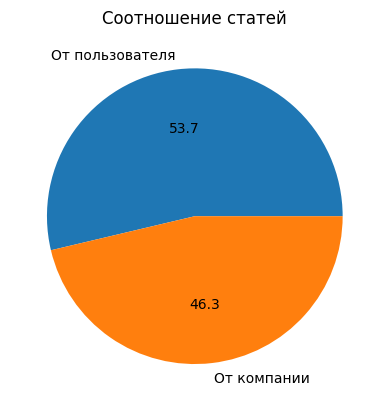

In [5]:
x = df2.groupby(by='target').count()
print(x['text'])
plt.pie(x['theme'], labels=['От пользователя', 'От компании'],  autopct='%.1f')
plt.title('Соотношение статей')

In [6]:
df2 = pd.concat((df2[df2['target']==0][:2000], df2[df2['target']==1][:2000]))
len(df2), len(df2[df2['target']==0])

(4000, 2000)

In [6]:
df2['text'][2][:400] # текст был обработан в прошлом блокноте

'исследование российский учёный подтвердить существование эфирный эфир самый интересный научный гипотеза насчитывать тысяча iii век н э философский школа древний индия принять считать эфир лежать основа впоследствии исследователь называть эфир пятый элемент божественный сущность однако начало го век идея эфир решить отказаться невозможность определить свойство научный путём наука стоить место день '

In [7]:
unique_words = set(' '.join(df2['text']).split())
tokens = {value: key for key, value in enumerate(unique_words, start=1)}
print('Количество токенов:', len(tokens))

Количество токенов: 17916


In [8]:
text_len = 860
text_array = np.zeros((len(df2), text_len))

for i, text in enumerate(df2['text']):
    for j, word in enumerate(text.split()[:text_len]):
        if word in tokens.keys():
            text_array[i,j]=tokens[word]

text_array.shape

(4000, 860)

In [9]:
target = df2['target'].to_list()
target = np.array(target).reshape(-1, 1)
target, target.shape

(array([[0],
        [0],
        [0],
        ...,
        [1],
        [1],
        [1]]),
 (4000, 1))

In [10]:
X_train, X_test, y_train, y_test = train_test_split(text_array, target, test_size=0.3, random_state=42)
len(X_train), len(X_test)

(2800, 1200)

In [11]:
train_x, train_y = torch.IntTensor(X_train), torch.Tensor(y_train)
test_x, test_y = torch.IntTensor(X_test), torch.Tensor(y_test)

train_ds = TensorDataset(train_x, train_y)
test_ds = TensorDataset(test_x, test_y)

batch_size = 50

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=True)

In [1]:
# next(iter(train_dl))

In [25]:
class CompanyDetector(nn.Module):
    def __init__(self, input_size, embedding_dim, hidden_size, output_size):
        super(CompanyDetector, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.embedding = nn.Embedding(input_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_size, num_layers=2, batch_first=True, dropout=0.3)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sig = nn.Sigmoid()

    def forward(self, text):
        embedded = self.embedding(text)
        output, hidden = self.gru(embedded)

        output = self.fc(output[:, -1, :])
        output = self.sig(output)
       
        return output

In [13]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# device =  torch.device("cpu")

In [39]:
model = CompanyDetector(input_size=len(tokens) + 1,
            embedding_dim=256,
            hidden_size=512,
            output_size=1
)

model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.BCELoss()

print(model)

CompanyDetector(
  (embedding): Embedding(17917, 256)
  (gru): GRU(256, 512, num_layers=2, batch_first=True, dropout=0.15)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (sig): Sigmoid()
)


In [33]:
def predict(model, dl):
    outputs = []
    corr_y = []
    with torch.no_grad():
        for i, (X, y) in enumerate(dl):
            X = X.to(device)
            y = y.float().to(device)
            outputs.extend(model(X))
            corr_y.extend(y)
    return outputs, corr_y

In [34]:
def accuracy(predicted, y):
    right = 0
    for pred, target in zip(predicted, y):
        pred = 1 if pred > 0.5 else 0 
        right += pred == target

    return (right/len(predicted) * 100).item()

In [35]:
def train(model, epochs = 10, prefix='gru_'):
    start = time.time()
    
    for epoch in range(epochs):
        model.train()
        for i, data in enumerate(tqdm(train_dl)):
            text, target = data
            text = text.to(device)
            target = target.to(device)
    
        
            optimizer.zero_grad()
            outputs = model(text)
            loss = loss_fn(outputs, target.float())
            loss.backward()
            optimizer.step()
    
        tqdm.write(f'Epoch: {epoch}')
        torch.save(model, f'models/{prefix}{epoch}.pt')
        train_acc = predict(model, train_dl)
        test_acc = predict(model, test_dl)

        tqdm.write(f'Train accuracy: {accuracy(*train_acc):.2f}%')
        tqdm.write(f'Test accuracy: {accuracy(*test_acc):.2f}%')
   
        
    print(f'Total time: {(time.time() - start)/60:.2f} min')

In [40]:
train(model)

100%|███████████████████████████████████████████| 56/56 [00:20<00:00,  2.76it/s]


Epoch: 0
Train accuracy: 64.43%
Test accuracy: 58.25%


100%|███████████████████████████████████████████| 56/56 [00:20<00:00,  2.67it/s]


Epoch: 1
Train accuracy: 79.93%
Test accuracy: 58.67%


100%|███████████████████████████████████████████| 56/56 [00:20<00:00,  2.72it/s]


Epoch: 2
Train accuracy: 87.14%
Test accuracy: 60.67%


100%|███████████████████████████████████████████| 56/56 [00:20<00:00,  2.72it/s]


Epoch: 3
Train accuracy: 94.39%
Test accuracy: 63.08%


100%|███████████████████████████████████████████| 56/56 [00:20<00:00,  2.71it/s]


Epoch: 4
Train accuracy: 97.43%
Test accuracy: 63.75%


100%|███████████████████████████████████████████| 56/56 [00:20<00:00,  2.70it/s]


Epoch: 5
Train accuracy: 98.32%
Test accuracy: 64.08%


100%|███████████████████████████████████████████| 56/56 [00:20<00:00,  2.71it/s]


Epoch: 6
Train accuracy: 99.00%
Test accuracy: 62.50%


100%|███████████████████████████████████████████| 56/56 [00:20<00:00,  2.71it/s]


Epoch: 7
Train accuracy: 99.39%
Test accuracy: 62.58%


100%|███████████████████████████████████████████| 56/56 [00:21<00:00,  2.65it/s]


Epoch: 8
Train accuracy: 99.79%
Test accuracy: 63.67%


100%|███████████████████████████████████████████| 56/56 [00:20<00:00,  2.68it/s]


Epoch: 9
Train accuracy: 99.89%
Test accuracy: 62.08%
Total time: 5.30 min


In [42]:
model1 = torch.load('models/gru_5.pt', weights_only=False)
model1.eval()

CompanyDetector(
  (embedding): Embedding(17917, 256)
  (gru): GRU(256, 512, num_layers=2, batch_first=True, dropout=0.15)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (sig): Sigmoid()
)

In [48]:
test = predict(model1, test_dl)
pred = []
for i in test[0]:
    tmp = i.cpu()
    if tmp > 0.5:
        pred.append(1)
    else:
        pred.append(0)
    
test = [i.cpu() for i in test[1]]


accuracy_score = metrics.accuracy_score(pred, test)

print(f'Model accuracy = {accuracy_score*100:4.2f}%\n')
print('Classification Report:')
print(metrics.classification_report(test, pred))

Model accuracy = 63.67%

Classification Report:
              precision    recall  f1-score   support

         0.0       0.64      0.68      0.66       622
         1.0       0.63      0.59      0.61       578

    accuracy                           0.64      1200
   macro avg       0.64      0.63      0.63      1200
weighted avg       0.64      0.64      0.64      1200



Text(0.5, 1.0, 'Confusion Matrix')

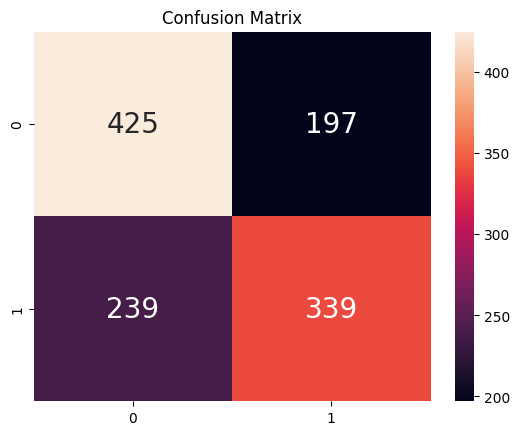

In [52]:
cm = pd.DataFrame(metrics.confusion_matrix(test, pred))
sns.heatmap(cm, annot=True, annot_kws={"size": 20}, fmt='.0f')
plt.title('Confusion Matrix')

# Многоклассовый классификатор

In [70]:
x = df.groupby('theme').count()
x = x.sort_values(by='url', ascending = False)[1:8]
top_themes = set(x['url'].index.to_list())
print(top_themes)

{'Блог компании Timeweb Cloud', 'Блог компании RUVDS.com', 'Блог компании ua-hosting.company', 'Математика*', 'Блог компании Онлайн Патент', 'Блог компании FirstVDS', 'Читальный зал'}


In [78]:
def choose_themes(row):
    if row['theme'] in top_themes:
        row['isRight'] = 1
        
    return row

df1 = df.apply(choose_themes, axis=1)
df1 = df1.dropna(subset=['isRight'])
df1.theme.unique(), df1.shape, df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1455 entries, 3 to 4336
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   amount_of_imgs   1455 non-null   int64  
 1   bookmark         1455 non-null   int64  
 2   comments         1455 non-null   int64  
 3   date             1455 non-null   object 
 4   isRight          1455 non-null   float64
 5   number_of_views  1455 non-null   int64  
 6   read_time        1455 non-null   int64  
 7   tags             1455 non-null   object 
 8   text             1455 non-null   object 
 9   theme            1455 non-null   object 
 10  title            1455 non-null   object 
 11  url              1455 non-null   object 
 12  votes            1455 non-null   int64  
dtypes: float64(1), int64(6), object(6)
memory usage: 159.1+ KB


(array(['Блог компании Timeweb Cloud', 'Блог компании ua-hosting.company',
        'Блог компании FirstVDS', 'Блог компании Онлайн Патент',
        'Блог компании RUVDS.com', 'Читальный зал', 'Математика*'],
       dtype=object),
 (1455, 13),
 None)

In [79]:
unique_words = set(' '.join(df2['text']).split())
tokens = {value: key for key, value in enumerate(unique_words, start=1)}
print('Количество токенов:', len(tokens))

Количество токенов: 17916


In [82]:
df1['text'].map(lambda x: len(x.split())).describe()

count    1455.000000
mean     1352.079725
std       713.777762
min        83.000000
25%       898.500000
50%      1249.000000
75%      1675.500000
max      7607.000000
Name: text, dtype: float64

In [84]:
text_len = 720
text_array = np.zeros((len(df1), text_len))

for i, text in enumerate(df1['text']):
    for j, word in enumerate(text.split()[:text_len]):
        if word in tokens.keys():
            text_array[i,j]=tokens[word]

text_array.shape

(1455, 720)

In [92]:
target_enc = OneHotEncoder(handle_unknown='ignore')
X = df1['theme'].to_numpy().reshape(-1, 1)

unique_items = np.unique(X).reshape(-1, 1)
target_enc.fit(unique_items)

print('Категории:', target_enc.categories_, sep='\n')
print()
for i in target_enc.categories_[0]:
    print(desc, i, target_enc.transform(np.array([i]).reshape(-1, 1)).toarray())

Категории:
[array(['Блог компании FirstVDS', 'Блог компании RUVDS.com',
       'Блог компании Timeweb Cloud', 'Блог компании ua-hosting.company',
       'Блог компании Онлайн Патент', 'Математика*', 'Читальный зал'],
      dtype=object)]

Читальный зал Блог компании FirstVDS [[1. 0. 0. 0. 0. 0. 0.]]
Читальный зал Блог компании RUVDS.com [[0. 1. 0. 0. 0. 0. 0.]]
Читальный зал Блог компании Timeweb Cloud [[0. 0. 1. 0. 0. 0. 0.]]
Читальный зал Блог компании ua-hosting.company [[0. 0. 0. 1. 0. 0. 0.]]
Читальный зал Блог компании Онлайн Патент [[0. 0. 0. 0. 1. 0. 0.]]
Читальный зал Математика* [[0. 0. 0. 0. 0. 1. 0.]]
Читальный зал Читальный зал [[0. 0. 0. 0. 0. 0. 1.]]


In [93]:
array = df1.theme.to_numpy().reshape(-1, 1)
target = target_enc.transform(array).toarray()

In [95]:
target.shape

(1455, 7)

In [98]:
X_train, X_test, y_train, y_test = train_test_split(text_array[:-5], target[:-5], test_size=0.3, random_state=42)
len(X_train), len(X_test)

(1015, 435)

In [102]:
# Балансировка
def get_sampler(data):
    x = [np.argmax(i) for i in data]
    counter = Counter(x)
    weights = [1/counter.get(i) for i in x]
    print(counter, sum(weights) ,len(data))
    return WeightedRandomSampler(weights, num_samples=len(weights))

train_sampler = get_sampler(y_train)
test_sampler = get_sampler(y_test)

Counter({np.int64(1): 248, np.int64(3): 190, np.int64(0): 145, np.int64(2): 140, np.int64(6): 132, np.int64(4): 80, np.int64(5): 80}) 6.999999999999967 1015
Counter({np.int64(3): 89, np.int64(1): 88, np.int64(0): 73, np.int64(6): 64, np.int64(2): 52, np.int64(5): 40, np.int64(4): 29}) 7.000000000000004 435


In [103]:
train_x, train_y = torch.IntTensor(X_train), torch.Tensor(y_train)
test_x, test_y = torch.IntTensor(X_test), torch.Tensor(y_test)

train_ds = TensorDataset(train_x, train_y)
test_ds = TensorDataset(test_x, test_y)

batch_size = 5

train_dl = DataLoader(train_ds, batch_size=batch_size, sampler=train_sampler)
test_dl = DataLoader(test_ds, batch_size=batch_size, sampler=test_sampler)

In [112]:
class ThemeDetector(nn.Module):
    def __init__(self, input_size, embedding_dim, hidden_size, output_size):
        super(CompanyDetector, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.embedding = nn.Embedding(input_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_size, num_layers=3, batch_first=True, dropout=0.3)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sig = nn.Sigmoid()

    def forward(self, text):
        embedded = self.embedding(text)
        output, hidden = self.gru(embedded)

        output = self.fc(output[:, -1, :])
        output = self.sig(output)
       
        return output

In [113]:
model = ThemeDetector(input_size=len(tokens) + 1,
            embedding_dim=256,
            hidden_size=512,
            output_size=7
)

model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
loss_fn = nn.BCELoss()

print(model)

CompanyDetector(
  (embedding): Embedding(17917, 256)
  (gru): GRU(256, 512, num_layers=2, batch_first=True, dropout=0.15)
  (fc): Linear(in_features=512, out_features=7, bias=True)
  (sig): Sigmoid()
)


In [109]:
def accuracy(predicted, y):
    right = 0
    for pred, target in zip(predicted, y):
        right += pred.argmax() == target.argmax()

    return (right/len(predicted) * 100).item()

In [114]:
train(model, prefix='gru_7_')

100%|█████████████████████████████████████████| 203/203 [00:19<00:00, 10.23it/s]


Epoch: 0
Train accuracy: 45.32%
Test accuracy: 17.70%


100%|█████████████████████████████████████████| 203/203 [00:19<00:00, 10.23it/s]


Epoch: 1
Train accuracy: 73.40%
Test accuracy: 28.05%


100%|█████████████████████████████████████████| 203/203 [00:19<00:00, 10.25it/s]


Epoch: 2
Train accuracy: 84.93%
Test accuracy: 39.31%


100%|█████████████████████████████████████████| 203/203 [00:20<00:00,  9.97it/s]


Epoch: 3
Train accuracy: 88.08%
Test accuracy: 28.74%


100%|█████████████████████████████████████████| 203/203 [00:20<00:00, 10.01it/s]


Epoch: 4
Train accuracy: 95.27%
Test accuracy: 31.03%


100%|█████████████████████████████████████████| 203/203 [00:19<00:00, 10.23it/s]


Epoch: 5
Train accuracy: 98.23%
Test accuracy: 29.43%


100%|█████████████████████████████████████████| 203/203 [00:19<00:00, 10.23it/s]


Epoch: 6
Train accuracy: 98.92%
Test accuracy: 35.40%


100%|█████████████████████████████████████████| 203/203 [00:19<00:00, 10.22it/s]


Epoch: 7
Train accuracy: 99.41%
Test accuracy: 30.80%


100%|█████████████████████████████████████████| 203/203 [00:19<00:00, 10.22it/s]


Epoch: 8
Train accuracy: 99.41%
Test accuracy: 38.39%


100%|█████████████████████████████████████████| 203/203 [00:19<00:00, 10.22it/s]


Epoch: 9
Train accuracy: 99.70%
Test accuracy: 35.63%
Total time: 5.21 min


In [115]:
model1 = torch.load('models/gru_7_2.pt', weights_only=False)
model1.eval()

ThemeDetector(
  (embedding): Embedding(17917, 256)
  (gru): GRU(256, 512, num_layers=2, batch_first=True, dropout=0.15)
  (fc): Linear(in_features=512, out_features=7, bias=True)
  (sig): Sigmoid()
)

In [123]:
values = predict(model1, test_dl)

pred = []
test = []
for i, j in zip(*values):
    pred.append(i.cpu().argmax())
    test.append(j.cpu().argmax())


accuracy_score = metrics.accuracy_score(pred, test)

print(f'Model accuracy = {accuracy_score*100:4.2f}%\n')
print('Classification Report:')
print(metrics.classification_report(test, pred))

Model accuracy = 38.85%

Classification Report:
              precision    recall  f1-score   support

           0       0.37      0.33      0.35        75
           1       0.23      0.33      0.27        63
           2       0.19      0.12      0.15        56
           3       0.54      0.73      0.62        60
           4       0.81      0.64      0.72        67
           5       0.37      0.35      0.36        48
           6       0.20      0.18      0.19        66

    accuracy                           0.39       435
   macro avg       0.39      0.39      0.38       435
weighted avg       0.39      0.39      0.38       435



Text(0.5, 1.0, 'Confusion Matrix')

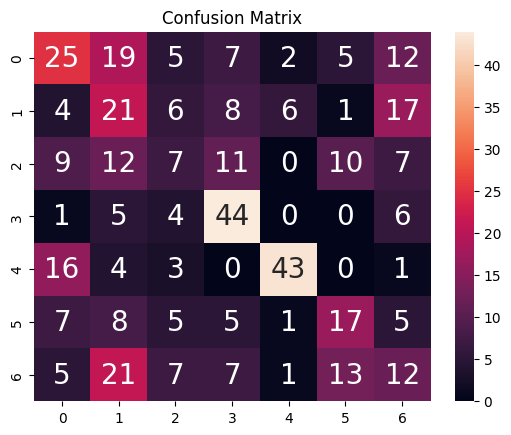

In [124]:
cm = pd.DataFrame(metrics.confusion_matrix(test, pred))
sns.heatmap(cm, annot=True, annot_kws={"size": 20}, fmt='.0f')
plt.title('Confusion Matrix')